# 代表値と尤度
統計データは要約をすることでおおよその分布が分かったり、また正規分布に従っていれば尖り具合(尖度)やデータの偏り(歪度)が分かる。またデータが正規分布に従っているのであればそのデータがどれだけ尤な値(尤度)を取っているかを調べる必要がある。ここで尤もな値とは得られた数値がどれくらいの割合で同時に発生するかを数値化したものになる。

# ライブラリのインポート

In [1]:
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

# データの取得

In [2]:
df1 = pd.read_html("https://bellcurve.jp/statistics/course/4320.html")[0]
df2 = pd.read_html("https://bellcurve.jp/statistics/course/4320.html")[1]
df = pd.concat([df1, df2], axis=1)
df

,0,1,2,3,0,1,2
0,階級,階級値,1組の度数,2組の度数,階級,階級値,3組の度数
1,140cm以上145cm未満,142.5,1,1,140cm以上145cm未満,142.5,2
2,145cm以上150cm未満,147.5,3,5,145cm以上150cm未満,147.5,0
3,150cm以上155cm未満,152.5,5,11,150cm以上155cm未満,152.5,1
4,155cm以上160cm未満,157.5,7,7,155cm以上160cm未満,157.5,2
5,160cm以上165cm未満,162.5,9,5,160cm以上165cm未満,162.5,5
6,165cm以上170cm未満,167.5,7,2,165cm以上170cm未満,167.5,7
7,170cm以上175cm未満,172.5,5,1,170cm以上175cm未満,172.5,11
8,175cm以上180cm未満,177.5,3,0,175cm以上180cm未満,177.5,5
9,180cm以上185cm未満,182.5,1,2,180cm以上185cm未満,182.5,1


# データの整形

In [3]:
arr = df.values
col = ["1組の度数","2組の度数","3組の度数"]
ind = arr[1:, 0]
cla_1 = arr[1:, 2].astype("float")
cla_2 = arr[1:, 3].astype("float")
cla_3 = arr[1:, 6].astype("float")
cla = np.vstack((cla_1, cla_2))
cla = np.vstack((cla, cla_3))
cla = cla.T
df = pd.DataFrame(cla)
df.columns = col
df.index = ind
df

,1組の度数,2組の度数,3組の度数
140cm以上145cm未満,1.0,1.0,2.0
145cm以上150cm未満,3.0,5.0,0.0
150cm以上155cm未満,5.0,11.0,1.0
155cm以上160cm未満,7.0,7.0,2.0
160cm以上165cm未満,9.0,5.0,5.0
165cm以上170cm未満,7.0,2.0,7.0
170cm以上175cm未満,5.0,1.0,11.0
175cm以上180cm未満,3.0,0.0,5.0
180cm以上185cm未満,1.0,2.0,1.0


# 尖度
尖度は分布の尖り具合を表している

In [4]:
df.skew()

1組の度数    0.146355
2組の度数    1.086613
3組の度数    1.086613
dtype: float64

# 歪度
歪度は分布の偏りを表している

In [5]:
df.kurt()

1組の度数   -1.060058
2組の度数    0.707149
3組の度数    0.707149
dtype: float64

# 要約統計量

In [6]:
pd.concat([df["1組の度数"].describe(), df["2組の度数"].describe(), df["3組の度数"].describe()], axis=1)

,1組の度数,2組の度数,3組の度数
count,9.000000,9.000000,9.000000
mean,4.555556,3.777778,3.777778
std,2.788867,3.562926,3.562926
min,1.000000,0.000000,0.000000
25%,3.000000,1.000000,1.000000
50%,5.000000,2.000000,2.000000
75%,7.000000,5.000000,5.000000
max,9.000000,11.000000,11.000000


# 尤度の計算
尤度の計算として、機械学習で予測した結果得られた正解率の分布を用いる。正解率の箱ひげ図と正規分布を確認する。また、尤度の計算では正規分布に対して対象のデータを用いて積を計算して同時発生する確率を算出する。

In [7]:
df = pd.read_csv("wine.csv")
df.head()

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
2,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
3,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
4,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


In [8]:
y_name = "Wine"
y = df["Wine"].values
x_table = df.drop(y_name, axis=1)
x = x_table.values

In [9]:
score = []
for i in range(50):
    x_train, x_test, y_train, y_test = tts(x, y, random_state=i, test_size=0.3)
    model = GBC()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    score.append(accuracy_score(y_test, y_pred))

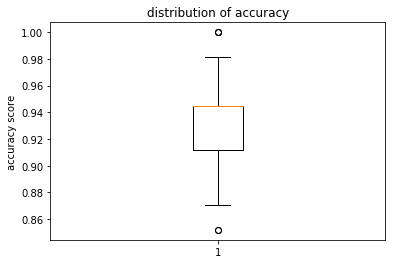

In [10]:
plt.boxplot(score)
plt.title("distribution of accuracy")
plt.ylabel("accuracy score")
plt.show()

## 尤度の計算

In [11]:
score = np.array(score)
L = (1 / ((2 * np.pi) ** 0.5) * np.std(score)) * np.exp( - (( score - np.mean(score)) ** 2) / 2)
np.prod(L)

1.4775015692973016e-93

## 対数での表現
尤度は確率の同時発生であるため限りなく0に近い値を取ることが多い。そこで、対数を用いてより分かりやすい数値に変える。

In [12]:
np.log(np.prod(L))

-213.75006111601854

## 正規分布での精度の分布

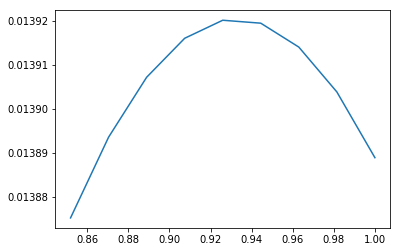

In [13]:
La = np.array([score,L]).T
La = np.array(sorted(La, key=lambda x: x[0]))
plt.plot(La[:,0], La[:,1])
plt.show()

## 箱ひげ図と正規分布を合わせて表示
箱ひげ図では四分位と最大値・最小値・外れ値・中央値が表示されるが、正規分布で表示することで具体的にどの数値が発生しやすいかが確認できる。

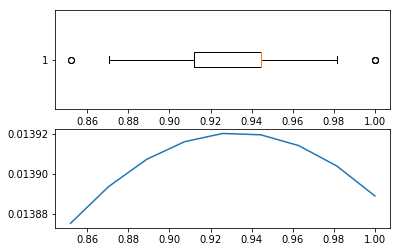

In [14]:
plt.subplot(2, 1, 1)
plt.boxplot(score, vert=False)
plt.subplot(2, 1, 2)
plt.plot(La[:,0], La[:,1])
plt.show()